In [34]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [35]:
def mascara(imagen):
    puntos_referencia = np.array([(1, 374), (1231, 374),(705, 176) ,(501, 176) ], dtype=np.int32)
    mascara = np.zeros_like(imagen)
    cv2.fillPoly(mascara, [puntos_referencia], (255, 255, 255)) 
    imagen_resultado = cv2.bitwise_and(imagen, mascara)
    return imagen_resultado

In [36]:
def draw_lines(img, lines, color=[255, 0, 0], thickness=7):
    for line in lines:
        for x1, y1, x2, y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

In [37]:
def rgb2gray(rgb):
    return np.dot(rgb[..., :3], [0.299, 0.587, 0.114]).astype(np.uint8)

In [38]:
def convolucion(imagen, kernel):
    altura, ancho = imagen.shape
    kaltura, kancho = kernel.shape
    khalf, kwhalf = kaltura // 2, kancho // 2
    salida = np.zeros((altura, ancho))
    
    for y in range(khalf, altura - khalf):
        for x in range(kwhalf, ancho - kwhalf):
            region = imagen[y - khalf:y + khalf + 1, x - kwhalf:x + kwhalf + 1]
            salida[y, x] = np.sum(region * kernel)
    
    return salida

In [39]:
def kernel_gaussiano(imagen):
    kernel_gaussiano = np.array([[1, 4,  7,  4,  1], 
                                [4, 16, 26, 16, 4], 
                                [7, 26, 41, 26, 7],
                                [4, 16, 26, 16, 4],
                                [1, 4,  7,  4,  1]]) / 273
    imagen_suavizada = convolucion(imagen, kernel_gaussiano)
    return imagen_suavizada

In [40]:
def canny(imagen_suavizada,umbral_bajo,umbral_alto):
    # Cálculo de gradientes
    kernel_sobel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    kernel_sobel_y = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])
    gradiente_x = convolucion(imagen_suavizada, kernel_sobel_x)
    gradiente_y = convolucion(imagen_suavizada, kernel_sobel_y)
 
    magnitud_gradiente = np.sqrt(gradiente_x**2 + gradiente_y**2)
    direccion_gradiente = np.arctan2(gradiente_y, gradiente_x)
    
    # Supresión de no máximos
    altura, ancho = imagen_suavizada.shape
    bordes_suprimidos = np.zeros((altura, ancho))
    
    for y in range(1, altura - 1):
        for x in range(1, ancho - 1):
            angulo = direccion_gradiente[y, x]
            # bordes horizontales de 0 a 180 grados
            if ((-np.pi/8 <= angulo <= np.pi/8) or
                (7*np.pi/8 <= angulo <= -7*np.pi/8)):
                if (magnitud_gradiente[y, x] >= magnitud_gradiente[y, x + 1]) and \
                   (magnitud_gradiente[y, x] >= magnitud_gradiente[y, x - 1]):
                    bordes_suprimidos[y, x] = magnitud_gradiente[y, x]
            #(diagonal superior derecha a inferior izquierda) y -45 grados (diagonal superior izquierda a inferior derecha)
            elif ((np.pi/8 <= angulo <= 3*np.pi/8) or
                  (-7*np.pi/8 <= angulo <= -5*np.pi/8)):
                if (magnitud_gradiente[y, x] >= magnitud_gradiente[y - 1, x + 1]) and \
                   (magnitud_gradiente[y, x] >= magnitud_gradiente[y + 1, x - 1]):
                    bordes_suprimidos[y, x] = magnitud_gradiente[y, x]
            # 90 grados (vertical) y -90 grados (vertical invertida).
            elif ((3*np.pi/8 <= angulo <= 5*np.pi/8) or
                  (-5*np.pi/8 <= angulo <= -3*np.pi/8)):
                if (magnitud_gradiente[y, x] >= magnitud_gradiente[y - 1, x]) and \
                   (magnitud_gradiente[y, x] >= magnitud_gradiente[y + 1, x]):
                    bordes_suprimidos[y, x] = magnitud_gradiente[y, x]
            # 135 grados y -135 grados
            else:
                if (magnitud_gradiente[y, x] >= magnitud_gradiente[y - 1, x - 1]) and \
                   (magnitud_gradiente[y, x] >= magnitud_gradiente[y + 1, x + 1]):
                    bordes_suprimidos[y, x] = magnitud_gradiente[y, x]
            # Umbralización por histéresis
    bordes = np.zeros((altura, ancho), dtype=np.uint8)
    for y in range(1, altura - 1):
        for x in range(1, ancho - 1):
            if bordes_suprimidos[y, x] >= umbral_alto:
                bordes[y, x] = 255
            elif bordes_suprimidos[y, x] >= umbral_bajo:
                vecindario = bordes_suprimidos[y-1:y+2, x-1:x+2]
                if np.any(vecindario >= umbral_alto):
                    bordes[y, x] = 255
                    
    return bordes.astype(np.uint8)

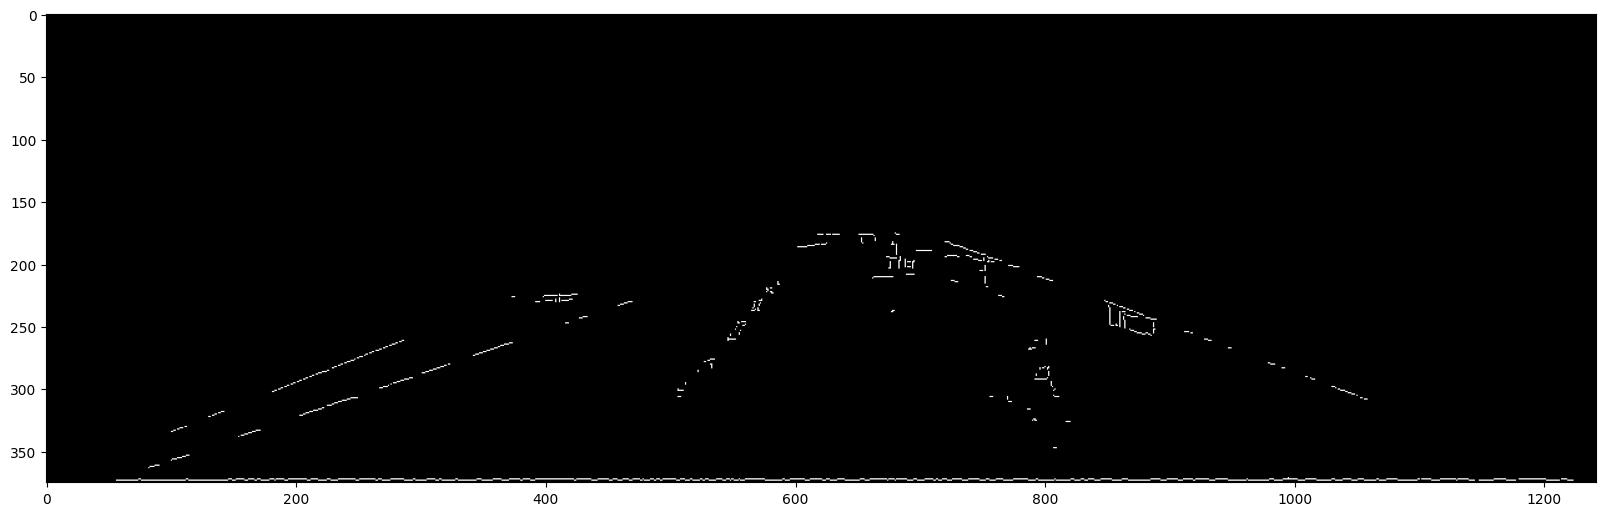

In [82]:
image = cv2.imread('carretera.png')

gray = rgb2gray(image)

cropped_image = mascara(gray)

blur = kernel_gaussiano(cropped_image)

low_t =50
high_t=
edges = canny(blur, low_t,high_t)

plt.figure(figsize=(20, 10))
plt.subplot(1, 1, 1)
plt.imshow(edges, cmap='gray')




In [ ]:
"""cropped_image = mascara(edges)

plt.figure(figsize=(20, 10))
plt.subplot(2, 1, 1)
plt.imshow(cropped_image, cmap='gray')

lines = cv2.HoughLinesP(cropped_image, 1, np.pi/180, 100, np.array([]), minLineLength=10, maxLineGap=10)

for line in lines:
    x1, y1, x2, y2 = line[0]
    cv2.line(image, (x1, y1), (x2, y2), (0, 255, 0), 2)  # Dibuja la línea en verde

plt.subplot(2, 1, 2)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)) """